# Emotion Recognition using Deep CNN

In [ ]:
import os
import numpy as np 
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Model imports
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2

In [14]:
def get_pixel_values(image_path):
    img = Image.open(image_path).convert('L').resize((48, 48))
    return list(img.getdata())

# Dynamically get emotion classes from emotion_data directory
emotion_data_dir = '/kaggle/input/emotion-data/emotion_data'
emotionList = [d for d in os.listdir(emotion_data_dir) if os.path.isdir(os.path.join(emotion_data_dir, d))]
emotionList.sort()  # Ensure consistent order
DigitAssigned = {emotion: idx for idx, emotion in enumerate(emotionList)}

#Find out Number of Images (Not Necessary)
no_of_images = 0
for emotion in emotionList:
    no_of_images += len(os.listdir(os.path.join(emotion_data_dir, emotion)))
no_of_images    

10382

In [15]:
# Training Data
all_image_pixel_values = []
all_emotion_labels = []
for emotion in emotionList:
    images = os.listdir(os.path.join(emotion_data_dir, emotion))
    image_paths = [os.path.join(emotion_data_dir, emotion, img) for img in images]
    image_pixel_values = [get_pixel_values(img_path) for img_path in image_paths]
    all_image_pixel_values.extend(image_pixel_values)
    all_emotion_labels.extend([DigitAssigned[emotion]] * len(image_pixel_values))

X_train, X_test, y_train, y_test = train_test_split(
    np.array(all_image_pixel_values), 
    np.array(all_emotion_labels), 
    test_size=0.2, 
    random_state=42
)

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (8305, 2304)
Training labels shape: (8305,)
Testing data shape: (2077, 2304)
Testing labels shape: (2077,)


In [16]:
#Dividing by 255 to normalize
X_train = X_train / 255.0
X_test = X_test / 255.0

#Reshaping the array
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

print("X_train shape after reshape:", X_train.shape)
print("X_test shape after reshape:", X_test.shape)

#One hot encoding
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

#Creating Validation Set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train shape after reshape: (8305, 48, 48, 1)
X_test shape after reshape: (2077, 48, 48, 1)


## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator



train_datagen = ImageDataGenerator(
    rotation_range=20,           # Randomly rotate images by up to 20 degrees
    width_shift_range=0.1,       # Randomly shift images horizontally by up to 10%
    height_shift_range=0.1,      # Randomly shift images vertically by up to 10%
    shear_range=0.1,            # Shear transformations
    zoom_range=0.1,             # Random zoom
    horizontal_flip=True,        # Random horizontal flips
    fill_mode='nearest',         # Fill mode for newly created pixels
    brightness_range=[0.8, 1.2], # Random brightness adjustment
    channel_shift_range=0.1      # Random channel shifts
)


val_test_datagen = ImageDataGenerator()

train_datagen.fit(X_train)

# Create augmented training generator
batch_size = 64
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_test_datagen.flow(X_val, y_val, batch_size=batch_size)


In [17]:


from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
)
from tensorflow.keras.models import Model

def Emotion_Model(input_shape=(48, 48, 1)):
    inputImg = Input(shape=input_shape, name='input')
    num_classes = len(emotionList)

    # Block 1
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name='conv1_1')(inputImg)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name='conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2, 2), name='pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name='drop1_1')(pool1_1)

    # Block 2
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name='conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name='conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name='conv2_3')(conv2_2)
    conv2_3 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2, 2), name='pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name='drop2_1')(pool2_1)

    # Block 3
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2, 2), name='pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name='drop3_1')(pool3_1)

    # Block 4
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2, 2), name='pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name='drop4_1')(pool4_1)

    # Block 5
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv5_4')(conv5_3)
    conv5_4 = BatchNormalization()(conv5_4)
    pool5_1 = MaxPooling2D(pool_size=(2, 2), name='pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name='drop5_1')(pool5_1)

    # Fully Connected Layers
    flatten = Flatten(name='flatten')(drop5_1)
    output = Dense(num_classes, activation='softmax', name='output')(flatten)

    # Model Definition
    model = Model(inputs=inputImg, outputs=output)

    print(model.summary())

    return model

In [ ]:


checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

#Model Compilation
model = Emotion_Model()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#Training the Model with Data Augmentation
ModelHistory = model.fit(train_generator,
                    epochs=100,
                    steps_per_epoch=len(X_train) // batch_size,
                    verbose=1,
                    callbacks=checkpointer,
                    validation_data=val_generator,
                    validation_steps=len(X_val) // batch_size)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_1 (Conv2D)                     │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_2 (Conv2D)                     │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1_1 (MaxPooling2D)               │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop1_1 (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1 (Conv2D)                     │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_2 (Conv2D)                     │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_3 (Conv2D)                     │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2_1 (MaxPooling2D)               │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop2_1 (Dropout)                    │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_1 (Conv2D)                     │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_2 (Conv2D)                     │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 13,113,414 (50.02 MB)

 Trainable params: 13,104,198 (49.99 MB)

 Non-trainable params: 9,216 (36.00 KB)

None
Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2252 - loss: 3.4573
Epoch 1: val_accuracy improved from -inf to 0.15029, saving model to best_model.h5
130/130 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.2256 - loss: 3.4507 - val_accuracy: 0.1503 - val_loss: 1.9598
Epoch 2/100
129/130 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3579 - loss: 1.6909
Epoch 2: val_accuracy did not improve from 0.15029
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.3582 - loss: 1.6888 - val_accuracy: 0.1426 - val_loss: 2.2069
Epoch 3/100
129/130 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4635 - loss: 1.3066
Epoch 3: val_accuracy improved from 0.15029 to 0.18786, saving model to best_model.h5
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.4635 - loss: 1.3064 - val_accuracy: 0.1879 - val_loss: 3.5388
Epoch 4/100
129/130 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4917 - loss: 1.2813
Epoch 4: val_accuracy improved from 0.18786 to 0.31310, saving mod

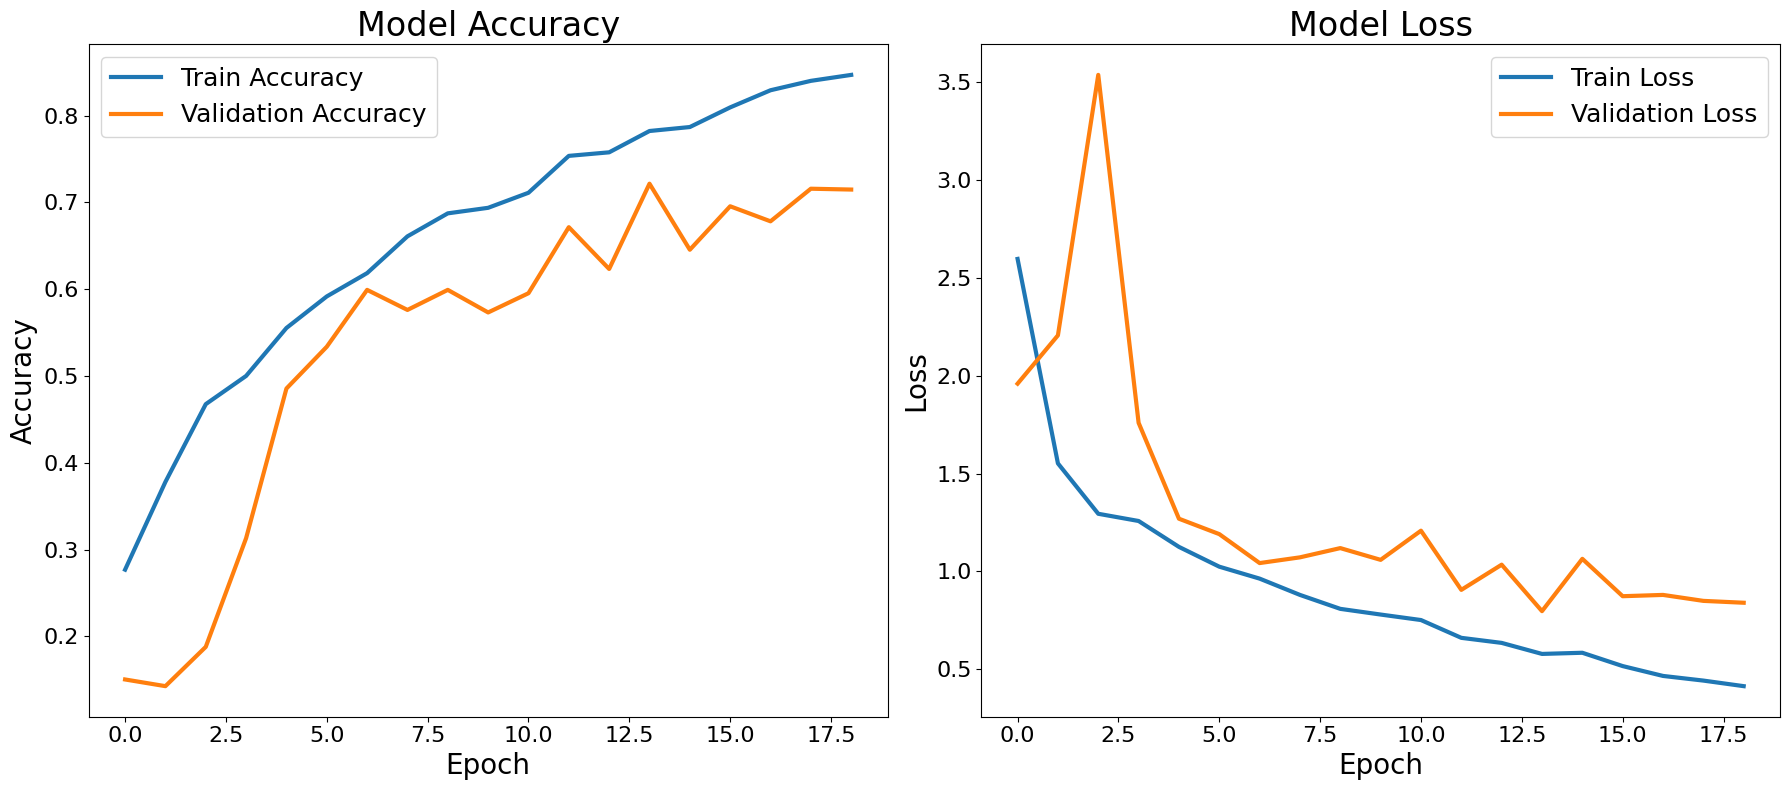

In [ ]:
import matplotlib.pyplot as plt
import time
import subprocess
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Increase overall figure size
plt.figure(figsize=(18,8))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(ModelHistory.history['accuracy'], label='Train Accuracy', linewidth=3)
plt.plot(ModelHistory.history['val_accuracy'], label='Validation Accuracy', linewidth=3)
plt.title('Model Accuracy', fontsize=24)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(ModelHistory.history['loss'], label='Train Loss', linewidth=3)
plt.plot(ModelHistory.history['val_loss'], label='Validation Loss', linewidth=3)
plt.title('Model Loss', fontsize=24)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6557 - loss: 1.0033

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step

📊 Total Images: 1039
⏱️ Total Prediction Time: 2.6466 seconds
⚡ Images per Second (Throughput): 392.59
🧠 Average Time per Image: 0.0025 seconds

🖥️ Fetching GPU usage details...

🔋 GPU Power Draw: 45.97 W
🚀 GPU Utilization: 0.0%
📦 GPU Memory Used: 4377.0 MiB / 16384.0 MiB

📄 Classification Report:
               precision    recall  f1-score   support

     boredom       0.54      0.63      0.58       175
     confuse       0.56      0.53      0.55       172
       focus       0.68      0.67      0.67       202
  frustrated       0.67      0.56      0.61       169
      sleepy       0.81      0.81      0.81       160
     yawning       0.91      0.95      0.93       161

    accuracy                           0.69      1039
   macro avg       0.69      0.69      0.69      1039
weighted avg       0.69      0.69      0.69      1039



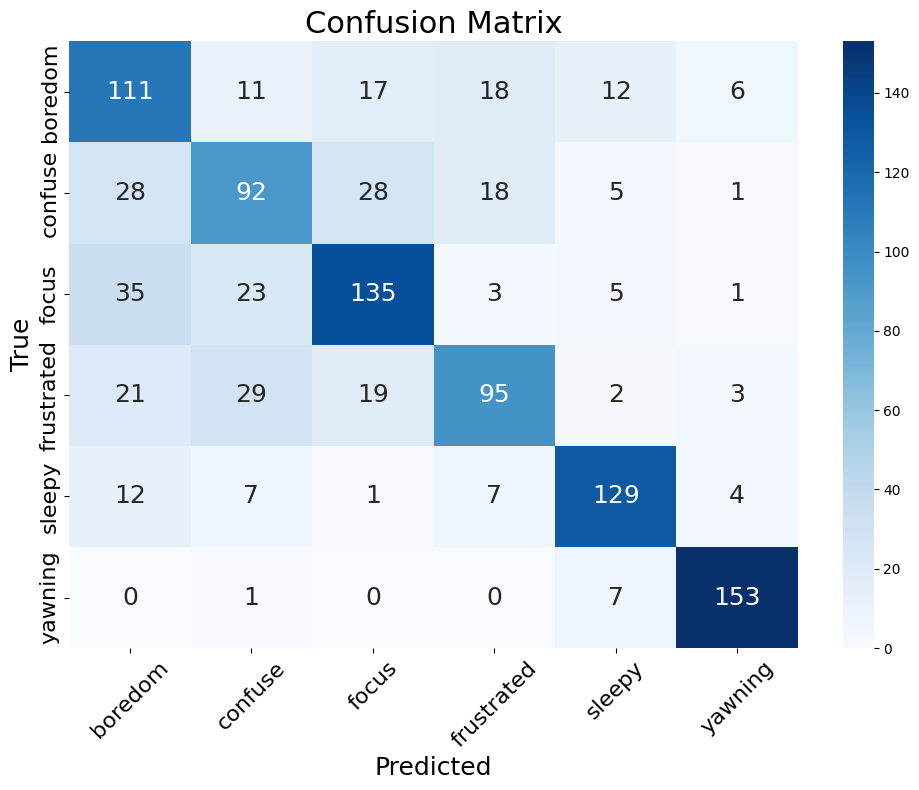

/tmp/ipykernel_35/3878483304.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


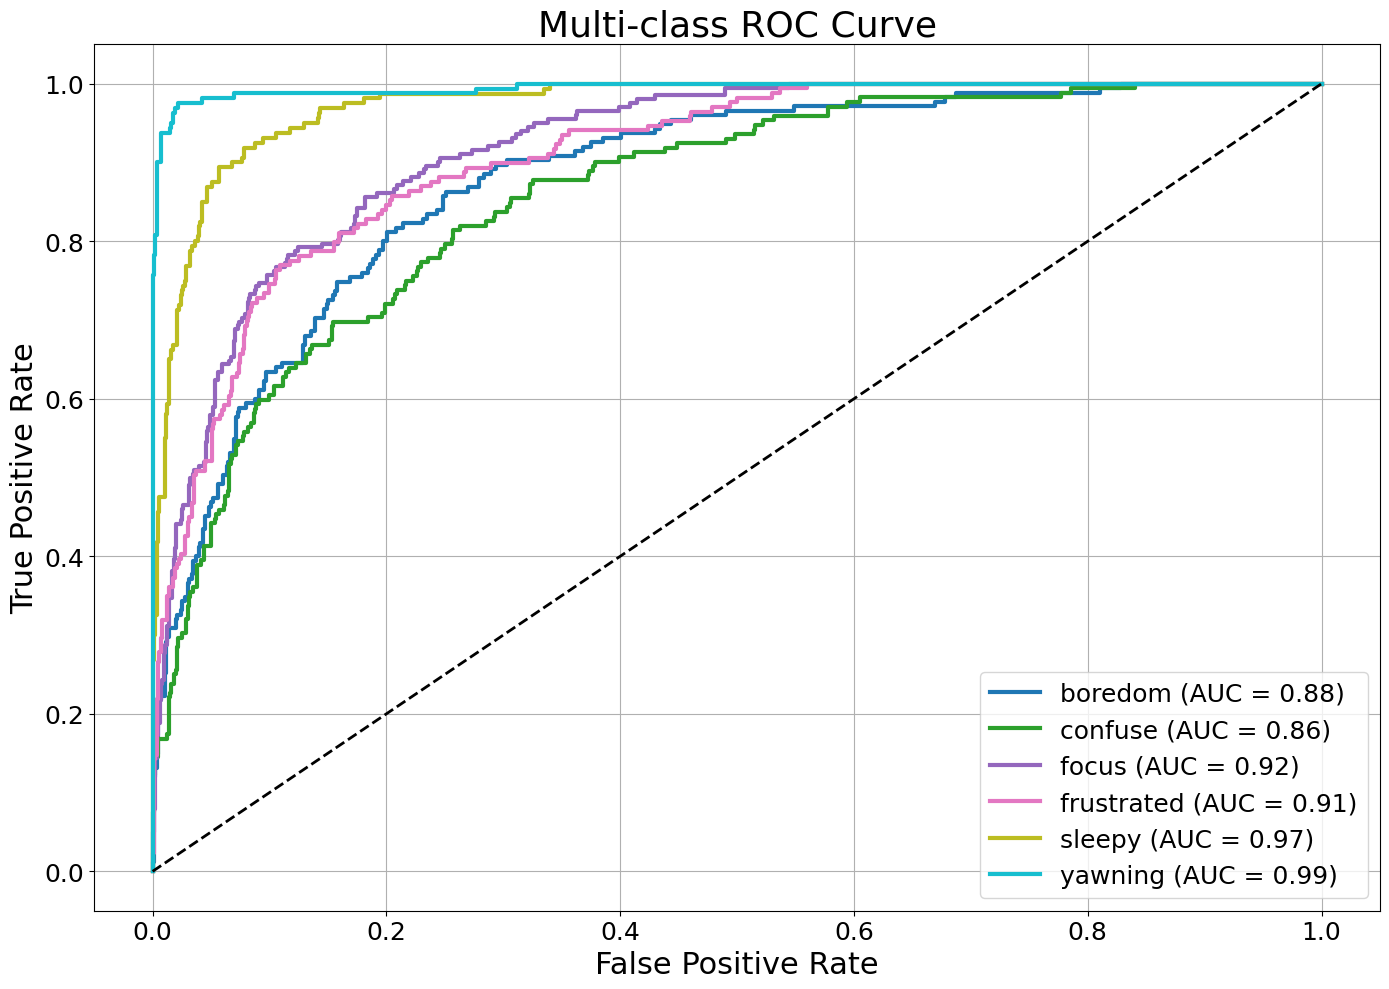

In [20]:


# --- Evaluation ---
loss = model.evaluate(X_test, y_test)  # Keep this line to print progress bar (e.g., 33/33 ━━ ...)
print()

# --- Timing Start ---
start_time = time.time()
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
end_time = time.time()

# --- Metrics Calculation ---
elapsed_time = end_time - start_time
num_images = len(y_true)
images_per_second = num_images / elapsed_time
avg_time_per_image = elapsed_time / num_images

# --- Speed/Performance Print ---
print(f"\n📊 Total Images: {num_images}")
print(f"⏱️ Total Prediction Time: {elapsed_time:.4f} seconds")
print(f"⚡ Images per Second (Throughput): {images_per_second:.2f}")
print(f"🧠 Average Time per Image: {avg_time_per_image:.4f} seconds")

# --- GPU Stats ---
print("\n🖥️ Fetching GPU usage details...\n")
try:
    gpu_stats = subprocess.check_output([
        "nvidia-smi",
        "--query-gpu=power.draw,utilization.gpu,memory.used,memory.total",
        "--format=csv,noheader,nounits"
    ])
    gpu_stats = gpu_stats.decode("utf-8").strip().split('\n')[0]
    power_draw, gpu_util, mem_used, mem_total = map(float, gpu_stats.split(', '))

    print(f"🔋 GPU Power Draw: {power_draw:.2f} W")
    print(f"🚀 GPU Utilization: {gpu_util:.1f}%")
    print(f"📦 GPU Memory Used: {mem_used:.1f} MiB / {mem_total:.1f} MiB")

except Exception as e:
    print("❌ Could not fetch GPU metrics:", str(e))

# --- Classification Report ---
print("\n📄 Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=emotionList))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotionList, yticklabels=emotionList,
            annot_kws={"size": 18})
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('Confusion Matrix', fontsize=22)
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

# --- ROC Curve for Multi-class ---
y_true_bin = label_binarize(y_true, classes=range(len(emotionList)))
n_classes = y_true_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(14, 10))
colors = plt.cm.get_cmap('tab10', n_classes)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=3,
             label=f'{emotionList[i]} (AUC = {roc_auc[i]:.2f})',
             color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('Multi-class ROC Curve', fontsize=26)
plt.legend(loc='lower right', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()
